# Senior data analyst challenge - Guillermo Trujillo
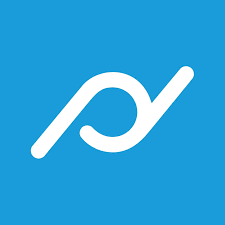

This notebook, created as part of an interview test, analyzes trial-to-paid customer conversions while fully complying with GDPR regulations (all data is anonymized and handled in accordance with privacy standards).

The goal is to help establish a baseline that can guide the product team in creating better user experiences, leading to an increase in the activation of trial customers. More specifically, in this notebook I will proceed as it follows:

- Evaluate which are the top activities that distinguish converterd organisations.
- Identify the common activity transitions that lead to conversion.
- Calculate the amount of time it takes for each organisation to convert after trial starts.
- Establish a baseline for time-to-conversion (e.g., *80% of converting trials upgrade within 30 days of start*).
- Use these findings to define a clear trial conversion goal.

### 🧽 Data importing and cleaning 🧽

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('senior_da_task.csv')

Saving senior_da_task.csv to senior_da_task (1).csv


In [5]:
df_all = df #creating a copy of the dataframe
df_all.head()

,ORGANIZATION_ID,ACTIVITY_NAME,TIMESTAMP,CONVERTED,CONVERTED_AT,TRIAL_START,TRIAL_END
0,0040dd9ab132b92d5d04bc3acf14d2e2,Scheduling.Shift.Created,2024-03-27 11:03:53.000,False,NaN,2024-03-27 10:11:39.000,2024-04-26 10:11:39.000
1,0040dd9ab132b92d5d04bc3acf14d2e2,Scheduling.Shift.Created,2024-03-27 11:04:52.000,False,NaN,2024-03-27 10:11:39.000,2024-04-26 10:11:39.000
2,0040dd9ab132b92d5d04bc3acf14d2e2,Scheduling.Shift.Created,2024-03-27 11:04:53.000,False,NaN,2024-03-27 10:11:39.000,2024-04-26 10:11:39.000
3,0040dd9ab132b92d5d04bc3acf14d2e2,Scheduling.Shift.Created,2024-03-27 11:05:18.000,False,NaN,2024-03-27 10:11:39.000,2024-04-26 10:11:39.000
4,0040dd9ab132b92d5d04bc3acf14d2e2,Scheduling.Shift.Created,2024-03-27 11:06:00.000,False,NaN,2024-03-27 10:11:39.000,2024-04-26 10:11:39.000


In [6]:
df_all.describe()

,ORGANIZATION_ID,ACTIVITY_NAME,TIMESTAMP,CONVERTED,CONVERTED_AT,TRIAL_START,TRIAL_END
count,170526,170526,170526,170526,34235,170526,170526
unique,966,28,99738,2,206,966,966
top,33f0b98a557961f5ccc519bb972d450f,Scheduling.Shift.Created,2024-03-11 13:25:12.000,False,2024-04-04 15:25:04.000,2024-03-20 11:01:59.000,2024-04-19 11:01:59.000
freq,12136,96895,512,136291,3826,12136,12136


**Some data quality checks:**

* There are only 966 unique organisations in this data set. Out of those, only 206 have ever converted. This is 21.3% ✅

* There seems to be no issue with NULL or NaN values in the dataset. Only the *converted_at* column contains null values (80% --> 136291 / 170526). ✅

* This is the same amount of values that have a CONVERTED = False. ✅
* We are converting all the time columns to datetime format ✅

In [7]:
#checking the data types of the columns in order to identify any potential data conversions
df_all.info()
df_all.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170526 entries, 0 to 170525
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ORGANIZATION_ID  170526 non-null  object
 1   ACTIVITY_NAME    170526 non-null  object
 2   TIMESTAMP        170526 non-null  object
 3   CONVERTED        170526 non-null  bool  
 4   CONVERTED_AT     34235 non-null   object
 5   TRIAL_START      170526 non-null  object
 6   TRIAL_END        170526 non-null  object
dtypes: bool(1), object(6)
memory usage: 8.0+ MB


,0
ORGANIZATION_ID,0
ACTIVITY_NAME,0
TIMESTAMP,0
CONVERTED,0
CONVERTED_AT,136291
TRIAL_START,0
TRIAL_END,0


In [8]:
# Parsing timestamp fields
df_all['CONVERTED_AT'] = pd.to_datetime(df_all['CONVERTED_AT'])
df_all['TIMESTAMP'] = pd.to_datetime(df_all['TIMESTAMP'])
df_all['TRIAL_START'] = pd.to_datetime(df_all['TRIAL_START'])
df_all['TRIAL_END'] = pd.to_datetime(df_all['TRIAL_END'])

In [9]:
total_users = df_all['ORGANIZATION_ID'].nunique() #more than one row per organization_id
converted_users = df_all[df_all['CONVERTED'] == True]['ORGANIZATION_ID'].nunique()

print(f"The total conversion rate of all the users registered between January and March of 2024 is: {(converted_users / total_users) * 100:.2f}% ({converted_users} out of {total_users} users)")

The total conversion rate of all the users registered between January and March of 2024 is: 21.33% (206 out of 966 users)


In [10]:
#Filtering out the non-converted users since they are not relevant for our analysis
converted_df = df_all[df_all['CONVERTED'] == True]

In [11]:
#counting the unique amount of organisations that have each activity.

converted_df.groupby('ACTIVITY_NAME')['ORGANIZATION_ID'].nunique().sort_values(ascending=False)

,ORGANIZATION_ID
ACTIVITY_NAME,
Scheduling.Shift.Created,185
Mobile.Schedule.Loaded,97
Scheduling.Shift.AssignmentChanged,74
PunchClock.PunchedIn,48
Scheduling.Shift.Approved,44
Scheduling.Template.ApplyModal.Applied,27
Communication.Message.Created,24
Scheduling.Availability.Set,13
Scheduling.OpenShiftRequest.Created,13


All activites that have less than 5 converted customers will be excluded for simplicity purposes

In [12]:
activities_to_exclude = ['Absence.Request.Rejected', 'Scheduling.ShiftHandover.Created',
                         'PunchClockEndNote.Add.Completed', 'PunchClockStartNote.Add.Completed',
                         'Scheduling.ShiftHandover.Accepted', 'Break.Activate.Finished',
                         'Break.Activate.Started', 'PunchClock.PunchedOut',
                         'Integration.Xero.PayrollExport.Synced', 'Scheduling.ShiftSwap.Created']


converted_df_filtered = converted_df[~converted_df['ACTIVITY_NAME'].isin(activities_to_exclude)]

In [13]:
converted_df_filtered.groupby('ACTIVITY_NAME')['ORGANIZATION_ID'].nunique().sort_values(ascending=False)

,ORGANIZATION_ID
ACTIVITY_NAME,
Scheduling.Shift.Created,185
Mobile.Schedule.Loaded,97
Scheduling.Shift.AssignmentChanged,74
PunchClock.PunchedIn,48
Scheduling.Shift.Approved,44
Scheduling.Template.ApplyModal.Applied,27
Communication.Message.Created,24
Scheduling.Availability.Set,13
Scheduling.OpenShiftRequest.Created,13


### 💡 EDA 💡

After we have cleaned up the dataset and filter the converted organisations (*converted_df*), in this part of the analysis the focus is to:

* Evaluate which are the top activities that distinguish converterd organisations.
* Identify the common activity transitions that lead to conversion.
* Calculate the amount of time it takes for each organisation to convert after trial starts.

In [14]:
activity_counts = converted_df.groupby(['ACTIVITY_NAME'])['ORGANIZATION_ID'].nunique().sort_index()

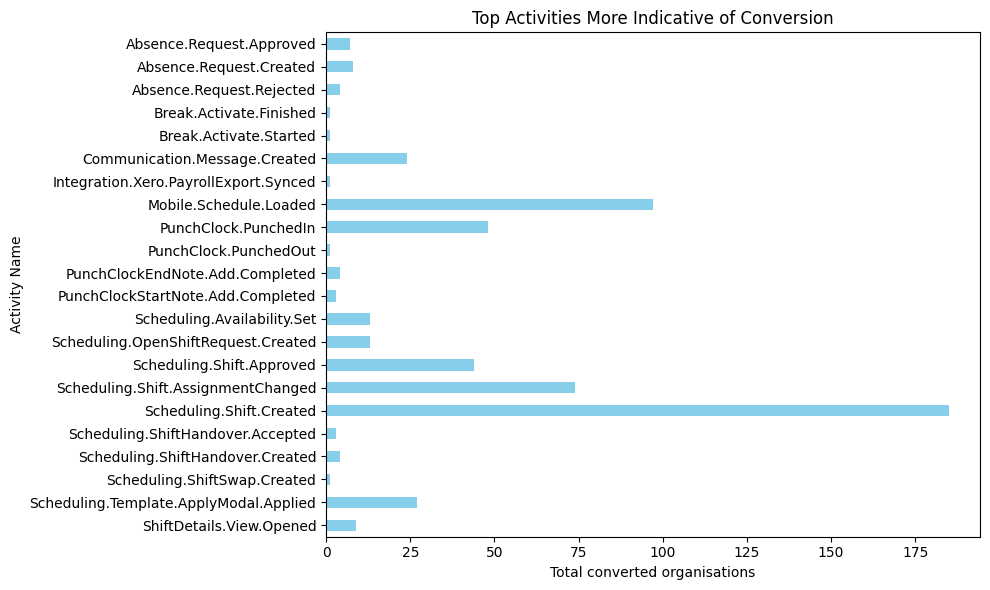

In [15]:

# 5. Plot
plt.figure(figsize=(10, 6))
activity_counts.plot(kind='barh', color='skyblue')
plt.xlabel("Total converted organisations")
plt.ylabel("Activity Name")
plt.title("Top Activities More Indicative of Conversion")
plt.gca().invert_yaxis()  # largest at top
plt.tight_layout()
plt.show()

💡💡💡 The activites most related to conversion are:


1.   Scheduling.Shift.Created: Creating new shifts
2.   Mobile.Schedule.Loaded: Viewing the overall schedule
3.   Scheduling.Shift.AssignmentChanged: Last-minute shift assignment
changes
4.   PunchClock.PunchedIn: Clocking in to work through the punch clock
5.   Scheduling.Shift.Approved: Approving open shift requests (as admin)


📆📆📆 **Analysis of user activity patterns shows that converted customers predominantly engage with scheduling-related features. The top activities among converters include creating new shifts, viewing the overall schedule, making last-minute shift assignment changes, clocking in via the punch clock, and approving open shift requests. This suggests that early and frequent use of the Scheduling functionality is strongly associated with conversion, indicating its central role in perceived product value.**


➡️➡️➡️ The next step will be to evaluate the most common pair of actions performed by these customers *(What do successful trial customers usually do after creating a new shift?)*

In [16]:
sequences = converted_df.groupby('ORGANIZATION_ID')['ACTIVITY_NAME'].apply(list)

from collections import Counter

sequence_counter = Counter(tuple(seq) for seq in sequences)

# Common full sequences might be unique, so you might want to look at subsequences:
# Here's a quick way to find frequent pairs of consecutive activities:
from itertools import chain

pairs = list(chain.from_iterable(
    [(seq[i], seq[i+1]) for i in range(len(seq)-1)] for seq in sequences
))

pair_counts = Counter(pairs)
top_pairs = pair_counts.most_common(15)

print(pair_counts.most_common(10))

[(('Scheduling.Shift.Created', 'Scheduling.Shift.Created'), 16785), (('Mobile.Schedule.Loaded', 'Mobile.Schedule.Loaded'), 9404), (('Scheduling.Shift.Created', 'Mobile.Schedule.Loaded'), 873), (('Mobile.Schedule.Loaded', 'Scheduling.Shift.Created'), 854), (('Scheduling.Shift.AssignmentChanged', 'Scheduling.Shift.AssignmentChanged'), 799), (('PunchClock.PunchedIn', 'Mobile.Schedule.Loaded'), 454), (('Mobile.Schedule.Loaded', 'PunchClock.PunchedIn'), 452), (('Scheduling.Shift.Created', 'Scheduling.Shift.AssignmentChanged'), 358), (('Scheduling.Shift.AssignmentChanged', 'Scheduling.Shift.Created'), 324), (('Scheduling.Shift.Approved', 'Scheduling.Shift.Approved'), 310)]


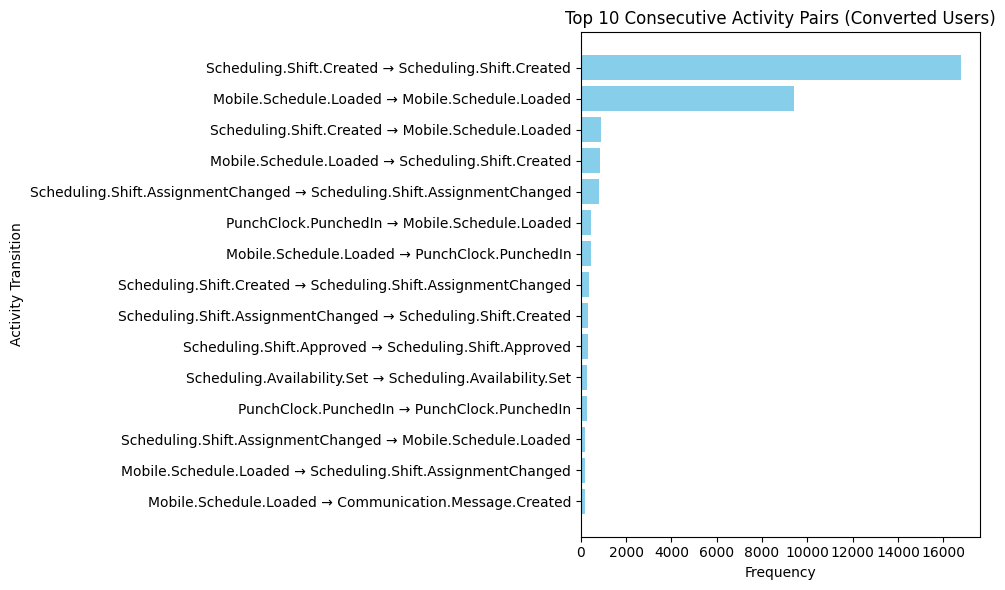

In [17]:
# Prepare for plotting
labels = [f"{a} → {b}" for a, b in dict(top_pairs).keys()]
counts = list(dict(top_pairs).values())

# Plot
plt.figure(figsize=(10, 6))
plt.barh(labels, counts, color='skyblue')
plt.xlabel("Frequency")
plt.ylabel("Activity Transition")
plt.title("Top 10 Consecutive Activity Pairs (Converted Users)")
plt.gca().invert_yaxis()  # Largest at top
plt.tight_layout()
plt.show()

In [18]:
#Checking an specific example of an organisation log of events.
#In this case the company's most common combination of events if creating shifts.

converted_df[converted_df['ORGANIZATION_ID']=='014f83e0deae3ac42041a126f1022974'].sort_values('TIMESTAMP')

,ORGANIZATION_ID,ACTIVITY_NAME,TIMESTAMP,CONVERTED,CONVERTED_AT,TRIAL_START,TRIAL_END
2784,014f83e0deae3ac42041a126f1022974,Scheduling.Shift.Created,2024-03-19 10:48:32,True,2024-04-12 10:48:32,2024-03-19 10:46:04,2024-04-18 10:46:04
2785,014f83e0deae3ac42041a126f1022974,Scheduling.Shift.AssignmentChanged,2024-03-19 10:48:38,True,2024-04-12 10:48:32,2024-03-19 10:46:04,2024-04-18 10:46:04
2786,014f83e0deae3ac42041a126f1022974,Scheduling.Shift.AssignmentChanged,2024-03-19 10:48:40,True,2024-04-12 10:48:32,2024-03-19 10:46:04,2024-04-18 10:46:04
2787,014f83e0deae3ac42041a126f1022974,Scheduling.Shift.Created,2024-03-19 10:55:04,True,2024-04-12 10:48:32,2024-03-19 10:46:04,2024-04-18 10:46:04
2788,014f83e0deae3ac42041a126f1022974,Scheduling.Shift.AssignmentChanged,2024-03-19 11:01:45,True,2024-04-12 10:48:32,2024-03-19 10:46:04,2024-04-18 10:46:04
...,...,...,...,...,...,...,...
2954,014f83e0deae3ac42041a126f1022974,Scheduling.Shift.Approved,2024-04-11 11:09:37,True,2024-04-12 10:48:32,2024-03-19 10:46:04,2024-04-18 10:46:04
2955,014f83e0deae3ac42041a126f1022974,Scheduling.Shift.Created,2024-04-11 11:10:35,True,2024-04-12 10:48:32,2024-03-19 10:46:04,2024-04-18 10:46:04
2956,014f83e0deae3ac42041a126f1022974,Scheduling.Shift.Created,2024-04-11 11:11:20,True,2024-04-12 10:48:32,2024-03-19 10:46:04,2024-04-18 10:46:04
2957,014f83e0deae3ac42041a126f1022974,Scheduling.Shift.Created,2024-04-15 13:18:36,True,2024-04-12 10:48:32,2024-03-19 10:46:04,2024-04-18 10:46:04


In [19]:
# Creating a function that creates a relative event index ("EVENT_INDEX") per organization compared to the moment of conversion

def number_relative_to_conversion(group):

    conv_time = group['CONVERTED_AT'].iloc[0]

    if pd.isna(conv_time):
        group['EVENT_INDEX'] = None

    else:
        # Get the position of the conversion event in the sorted list
        conv_idx = group.index[group['TIMESTAMP'] == conv_time]
        if len(conv_idx) == 0:
            # If there's no exact matching event timestamp for conversion, find closest one
            conv_idx = [group['TIMESTAMP'].sub(conv_time).abs().idxmin()]
        conv_pos = list(group.index).index(conv_idx[0])

        # Assign sequence numbers relative to conversion
        group['EVENT_INDEX'] = range(-conv_pos, len(group) - conv_pos)

    return group

In [20]:
converted_df_index = converted_df.groupby('ORGANIZATION_ID', group_keys=False).apply(number_relative_to_conversion)

/tmp/ipython-input-2994539089.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  converted_df_index = converted_df.groupby('ORGANIZATION_ID', group_keys=False).apply(number_relative_to_conversion)


In [21]:
converted_df_index[converted_df_index['ORGANIZATION_ID']=='014f83e0deae3ac42041a126f1022974'].sort_values('TIMESTAMP')

,ORGANIZATION_ID,ACTIVITY_NAME,TIMESTAMP,CONVERTED,CONVERTED_AT,TRIAL_START,TRIAL_END,EVENT_INDEX
2784,014f83e0deae3ac42041a126f1022974,Scheduling.Shift.Created,2024-03-19 10:48:32,True,2024-04-12 10:48:32,2024-03-19 10:46:04,2024-04-18 10:46:04,-172
2785,014f83e0deae3ac42041a126f1022974,Scheduling.Shift.AssignmentChanged,2024-03-19 10:48:38,True,2024-04-12 10:48:32,2024-03-19 10:46:04,2024-04-18 10:46:04,-171
2786,014f83e0deae3ac42041a126f1022974,Scheduling.Shift.AssignmentChanged,2024-03-19 10:48:40,True,2024-04-12 10:48:32,2024-03-19 10:46:04,2024-04-18 10:46:04,-170
2787,014f83e0deae3ac42041a126f1022974,Scheduling.Shift.Created,2024-03-19 10:55:04,True,2024-04-12 10:48:32,2024-03-19 10:46:04,2024-04-18 10:46:04,-169
2788,014f83e0deae3ac42041a126f1022974,Scheduling.Shift.AssignmentChanged,2024-03-19 11:01:45,True,2024-04-12 10:48:32,2024-03-19 10:46:04,2024-04-18 10:46:04,-168
...,...,...,...,...,...,...,...,...
2954,014f83e0deae3ac42041a126f1022974,Scheduling.Shift.Approved,2024-04-11 11:09:37,True,2024-04-12 10:48:32,2024-03-19 10:46:04,2024-04-18 10:46:04,-2
2955,014f83e0deae3ac42041a126f1022974,Scheduling.Shift.Created,2024-04-11 11:10:35,True,2024-04-12 10:48:32,2024-03-19 10:46:04,2024-04-18 10:46:04,-1
2956,014f83e0deae3ac42041a126f1022974,Scheduling.Shift.Created,2024-04-11 11:11:20,True,2024-04-12 10:48:32,2024-03-19 10:46:04,2024-04-18 10:46:04,0
2957,014f83e0deae3ac42041a126f1022974,Scheduling.Shift.Created,2024-04-15 13:18:36,True,2024-04-12 10:48:32,2024-03-19 10:46:04,2024-04-18 10:46:04,1


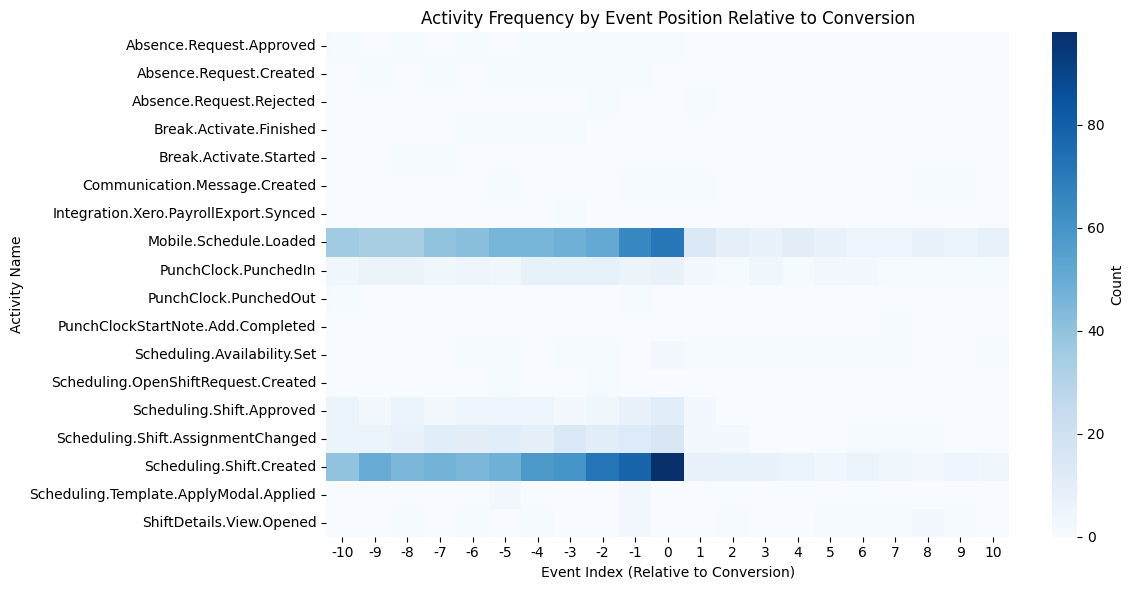

In [23]:
# Count occurrences of each (EVENT_INDEX, ACTIVITY_NAME) pair

converted_df_index_20 = converted_df_index[(converted_df_index['EVENT_INDEX']>=-10)&(converted_df_index['EVENT_INDEX']<=10)]

heatmap_data = (
    converted_df_index_20.groupby(['EVENT_INDEX', 'ACTIVITY_NAME'])
      .size()
      .unstack(fill_value=0)
)

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data.T, cmap="Blues", cbar_kws={'label': 'Count'})
plt.xlabel("Event Index (Relative to Conversion)")
plt.ylabel("Activity Name")
plt.title("Activity Frequency by Event Position Relative to Conversion")
plt.tight_layout()
plt.show()

💡💡💡 Examining activities immediately before and after conversion shows a consistent pattern: **new converted organizations most frequently create shifts and load schedules during this critical period**.

The heatmap confirms that these actions often occur in consecutive bursts, both leading up to and following conversion. This suggests that intense engagement with scheduling; specifically consecutive shift creation and schedule loading—serves as a strong behavioral signal of readiness to convert.

**We will focus on the shift creation activity (since this must happen before viewing the overall schedule) as the key indicator when defining trial success.**

The next step then is to evaluate how long does it take for trial customers to schedule their first shift since their trial started.

In [33]:
# Find first SHIFT CREATED timestamp per customer
first_shift_created = (
    df_all[df_all['ACTIVITY_NAME'] == 'Scheduling.Shift.Created']
    .groupby('ORGANIZATION_ID')['TIMESTAMP']
    .min()
)

# Map it back to the DataFrame
df_all['first_shift_created_ts'] = df_all['ORGANIZATION_ID'].map(first_shift_created)

In [34]:
df_all.head()

,ORGANIZATION_ID,ACTIVITY_NAME,TIMESTAMP,CONVERTED,CONVERTED_AT,TRIAL_START,TRIAL_END,first_shift_created_ts
0,0040dd9ab132b92d5d04bc3acf14d2e2,Scheduling.Shift.Created,2024-03-27 11:03:53,False,NaT,2024-03-27 10:11:39,2024-04-26 10:11:39,2024-03-27 11:03:53
1,0040dd9ab132b92d5d04bc3acf14d2e2,Scheduling.Shift.Created,2024-03-27 11:04:52,False,NaT,2024-03-27 10:11:39,2024-04-26 10:11:39,2024-03-27 11:03:53
2,0040dd9ab132b92d5d04bc3acf14d2e2,Scheduling.Shift.Created,2024-03-27 11:04:53,False,NaT,2024-03-27 10:11:39,2024-04-26 10:11:39,2024-03-27 11:03:53
3,0040dd9ab132b92d5d04bc3acf14d2e2,Scheduling.Shift.Created,2024-03-27 11:05:18,False,NaT,2024-03-27 10:11:39,2024-04-26 10:11:39,2024-03-27 11:03:53
4,0040dd9ab132b92d5d04bc3acf14d2e2,Scheduling.Shift.Created,2024-03-27 11:06:00,False,NaT,2024-03-27 10:11:39,2024-04-26 10:11:39,2024-03-27 11:03:53


In [37]:
df_all[df_all['CONVERTED']=='True'].describe()

,TIMESTAMP,CONVERTED_AT,TRIAL_START,TRIAL_END,first_shift_created_ts
count,0,0,0,0,0
mean,NaT,NaT,NaT,NaT,NaT
min,NaT,NaT,NaT,NaT,NaT
25%,NaT,NaT,NaT,NaT,NaT
50%,NaT,NaT,NaT,NaT,NaT
75%,NaT,NaT,NaT,NaT,NaT
max,NaT,NaT,NaT,NaT,NaT


In [41]:
# Creating new columns with relevant dates differences
# How long trials typically last
df_all['trial_length_days'] = (df_all['TRIAL_END'] - df_all['TRIAL_START']).dt.days

# Time from trial start to conversion
df_all['time_to_convert_days'] = (df_all['CONVERTED_AT'] - df_all['TRIAL_START']).dt.days

# Time from trial start to conversion
df_all['time_to_first_creation'] = (df_all['first_shift_created_ts'] - df_all['TRIAL_START']).dt.days

# Summary stats
print("Trial length (days) for converted customers:")
print(df_all['trial_length_days'][df_all['CONVERTED']==True].describe())

print("Trial length (days) for NON converted customers:")
print(df_all['trial_length_days'][df_all['CONVERTED']==False].describe())

print("Time to convert(days) for converted customers:")
print(df_all['time_to_convert_days'][df_all['CONVERTED']==True].describe())

print("\nTime from trial start to first shift creation (days) for converted customers:")
print(df_all['time_to_first_creation'][df_all['CONVERTED']==True].describe())

print("\nTime from trial start to first shift creation (days) for NON converted customers:")
print(df_all['time_to_first_creation'][df_all['CONVERTED']==False].describe())

Trial length (days) for converted customers:
count    34235.0
mean        30.0
std          0.0
min         30.0
25%         30.0
50%         30.0
75%         30.0
max         30.0
Name: trial_length_days, dtype: float64
Trial length (days) for NON converted customers:
count    136291.0
mean         30.0
std           0.0
min          30.0
25%          30.0
50%          30.0
75%          30.0
max          30.0
Name: trial_length_days, dtype: float64
Time to convert(days) for converted customers:
count    34235.000000
mean        30.171608
std          8.684251
min         14.000000
25%         23.000000
50%         30.000000
75%         39.000000
max         64.000000
Name: time_to_convert_days, dtype: float64

Time from trial start to first shift creation (days) for converted customers:
count    34118.000000
mean         1.225042
std          4.212878
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         28.000000
Name: time_to_first_creat

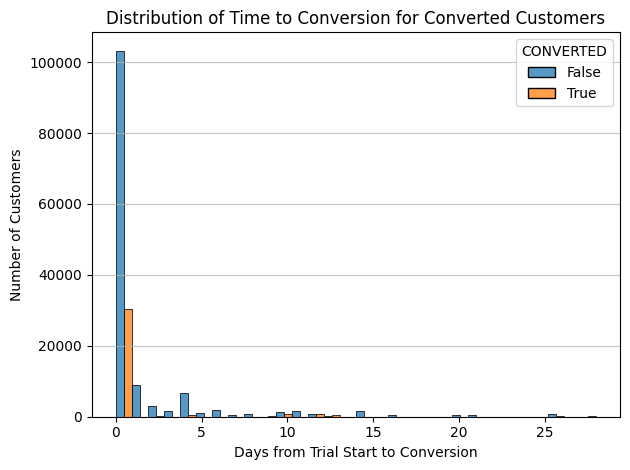

In [43]:
# Example: compare distribution of "days_active" for converted vs not
sns.histplot(data=df_all, x="time_to_first_creation", hue="CONVERTED", bins=30, kde=False, multiple="dodge")

plt.xlabel('Days from Trial Start to first shift creation')
plt.ylabel('Number of Customers')
plt.title('Distribution of Time to first shift creation for Converted Customers')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

In [46]:
#PARETO: How much time does it take for 80% of the customers to convert?

p80_converted = df_all['time_to_first_creation'][df_all['CONVERTED']==True].quantile(0.8)
p80_non_converted = df_all['time_to_first_creation'][df_all['CONVERTED']==False].quantile(0.8)

print(f"80% of converted customers create their first schedule within {p80_converted:.0f} days of trial start \n while 80% of NON converted customers create their first schedule within {p80_non_converted:.0f} days of trial start.")

80% of converted customers create their first schedule within 0 days of trial start 
 while 80% of NON converted customers create their first schedule within 1 days of trial start.


# 🤓 Findings and KPIs 🤓


- Converted trialists consistently lean into Scheduling features. In particular, they (1) create shifts and (2) load schedules. Most importantly, 80% of the converted customers create their first shift on Day 0 (the day the trial starts), while non-converters typically don’t. Given this clear behavioral split, **I suggest using First Shift Creation (FSC) as the primary KPI for trial activation.**


**Goal alignment: increasing the share of customers with FSC in day 0 should increase the share of trials that convert within the baseline conversion window.**